# Capstone Project for the Data Science Specialization

### Rafael Y. Imai - April 2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import parquet
#!pip install parquet
#!pip install fastparquet
#!pip install pyarrow


In [2]:
#parquet was used as it is quicker to read and lighter to store
#i wasn't able to upload the file, as even compacted it is close to 440MB...
historicSeries = pd.DataFrame()
    
historicSeries = pd.read_parquet('historicSeries.parquet')
historicSeries=historicSeries[["CNPJ_FUNDO","DT_COMPTC","VL_TOTAL","VL_QUOTA","VL_PATRIM_LIQ","CAPTC_DIA","RESG_DIA","NR_COTST"]]


Also, let's load a dataset with all of the investment funds that have existed since the early 90's in Brazil. This file was also obtained from CVM.

In [3]:
fundList = pd.read_excel("cad_fi_filtered.xlsx")  
fundList=fundList.rename(columns={'CNPJ_FUNDO':'CNPJ'})

In [4]:
historicSeries.describe()

,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
count,1.539843e+07,1.539843e+07,1.539843e+07,1.539843e+07,1.539843e+07,1.539843e+07
mean,4.509613e+08,1.502239e+04,4.491871e+08,2.829099e+06,2.752343e+06,1.059561e+03
std,3.028144e+09,2.302718e+07,3.008135e+09,7.038041e+07,6.968411e+07,2.113526e+04
min,-8.804822e+08,-3.259389e+07,-8.833179e+07,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.678671e+07,1.390819e+00,1.678042e+07,0.000000e+00,0.000000e+00,1.000000e+00
50%,4.723933e+07,2.874078e+00,4.717449e+07,0.000000e+00,0.000000e+00,2.000000e+00
75%,1.713284e+08,2.861168e+01,1.708142e+08,0.000000e+00,0.000000e+00,1.300000e+01
max,3.439999e+12,9.033537e+10,3.439999e+12,4.281956e+10,4.230832e+10,5.300000e+07


In [5]:
#filtering out fund datapoints whose number of shareholders is positive 
#(certainly negative shareholders indicate an error)

historicSeries = historicSeries[historicSeries["NR_COTST"]>0]
historicSeries.describe()

,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
count,1.533344e+07,1.533344e+07,1.533344e+07,1.533344e+07,1.533344e+07,1.533344e+07
mean,4.528262e+08,8.980956e+03,4.510454e+08,2.840776e+06,2.748153e+06,1.064052e+03
std,3.034366e+09,5.421404e+05,3.014360e+09,7.052736e+07,6.935020e+07,2.117989e+04
min,-8.804822e+08,-3.259389e+07,-8.833179e+07,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.698459e+07,1.398501e+00,1.697489e+07,0.000000e+00,0.000000e+00,1.000000e+00
50%,4.765799e+07,2.894943e+00,4.758310e+07,0.000000e+00,0.000000e+00,2.000000e+00
75%,1.725135e+08,2.892421e+01,1.719930e+08,0.000000e+00,0.000000e+00,1.300000e+01
max,3.439999e+12,1.130692e+08,3.439999e+12,4.281956e+10,4.230832e+10,5.300000e+07


In [6]:
#filtering out fund datapoints whose share value field is less than 0
historicSeries = historicSeries[historicSeries["VL_QUOTA"]>0]
historicSeries.describe()

,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
count,1.533021e+07,1.533021e+07,1.533021e+07,1.533021e+07,1.533021e+07,1.533021e+07
mean,4.529128e+08,8.985122e+03,4.511406e+08,2.841372e+06,2.748696e+06,1.064273e+03
std,3.034679e+09,5.421335e+05,3.014671e+09,7.053478e+07,6.935744e+07,2.118211e+04
min,-8.804822e+08,1.000000e-09,-2.191165e+04,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.699084e+07,1.399019e+00,1.698625e+07,0.000000e+00,0.000000e+00,1.000000e+00
50%,4.766917e+07,2.896464e+00,4.760719e+07,0.000000e+00,0.000000e+00,2.000000e+00
75%,1.725717e+08,2.895244e+01,1.720545e+08,0.000000e+00,0.000000e+00,1.300000e+01
max,3.439999e+12,1.130692e+08,3.439999e+12,4.281956e+10,4.230832e+10,5.300000e+07


In [7]:
#filtering out fund datapoints whose net worth field is less than 0
historicSeries = historicSeries[historicSeries["VL_PATRIM_LIQ"]>0]
historicSeries.describe()

,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
count,1.532976e+07,1.532976e+07,1.532976e+07,1.532976e+07,1.532976e+07,1.532976e+07
mean,4.529258e+08,8.985337e+03,4.511541e+08,2.841441e+06,2.747510e+06,1.064304e+03
std,3.034724e+09,5.421416e+05,3.014715e+09,7.053581e+07,6.933424e+07,2.118243e+04
min,-8.804822e+08,1.000000e-09,1.000000e-02,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.699188e+07,1.399031e+00,1.698798e+07,0.000000e+00,0.000000e+00,1.000000e+00
50%,4.767234e+07,2.896527e+00,4.761077e+07,0.000000e+00,0.000000e+00,2.000000e+00
75%,1.725813e+08,2.895275e+01,1.720642e+08,0.000000e+00,0.000000e+00,1.300000e+01
max,3.439999e+12,1.130692e+08,3.439999e+12,4.281956e+10,4.230832e+10,5.300000e+07


In [8]:
#filtering out fund datapoints whose total value field is less than 0
historicSeries = historicSeries[historicSeries["VL_TOTAL"]>0]
historicSeries.describe()

,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
count,1.532043e+07,1.532043e+07,1.532043e+07,1.532043e+07,1.532043e+07,1.532043e+07
mean,4.532022e+08,8.990639e+03,4.514139e+08,2.842590e+06,2.748612e+06,1.064741e+03
std,3.035627e+09,5.423066e+05,3.015605e+09,7.055543e+07,6.935348e+07,2.118886e+04
min,1.000000e-02,1.000000e-09,1.000000e-02,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.702424e+07,1.399870e+00,1.701665e+07,0.000000e+00,0.000000e+00,1.000000e+00
50%,4.774142e+07,2.898579e+00,4.767118e+07,0.000000e+00,0.000000e+00,2.000000e+00
75%,1.727540e+08,2.896075e+01,1.722238e+08,0.000000e+00,0.000000e+00,1.300000e+01
max,3.439999e+12,1.130692e+08,3.439999e+12,4.281956e+10,4.230832e+10,5.300000e+07


In [9]:
#calculating the capital flow...
historicSeries['CAP_LIQ']=historicSeries['CAPTC_DIA']-historicSeries['RESG_DIA']
#and the average ticket
historicSeries['TKT_MED']=historicSeries['VL_PATRIM_LIQ']/historicSeries['NR_COTST']

#### Historic series of the IBOVESPA index, the stock market index for the São Paulo Stock Exchange.

In [10]:
ibov = yf.Ticker('^BVSP')
ibovHistoric = ibov.history(start="2016-12-31",end="2021-1-1")
ibovHistoricClose = ibovHistoric[["Close"]] 
ibovHistoricClose = ibovHistoricClose.rename(columns={'Date':'DATE',"Close":"CLOSE"}) 

#### Data source of SELIC rate

In [11]:
url = "SELIC.csv"
#url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.1178/dados?formato=json&dataInicial=01/01/2017&dataFinal=31/12/2020"
selicData = pd.read_csv(url,sep=";")
selicData["data"]=pd.to_datetime(selicData["data"], format='%d/%m/%Y')
selicData["valor"] = selicData["valor"].str.replace(",",".")
selicData["valor"]=(((pd.to_numeric(selicData["valor"])/100+1)**252)-1)*100
selicData = selicData.set_index("data") 

In [12]:
#this function selects, out of the fund list, the ICVM #555 funds that still exist and were registered before 2017.
def mount_FirstLayer(lowerLimit,upperLimit):
    firstFundFilterLayer = fundList[fundList["TP_FUNDO"]=="FI"]
    firstFundFilterLayer = firstFundFilterLayer[firstFundFilterLayer["DT_REG"]<"2017-01-01"]
    firstFundFilterLayer = firstFundFilterLayer[(firstFundFilterLayer["SIT"]=="EM FUNCIONAMENTO NORMAL")]
    #The fund list file had some duplicate entries, which were dropped.
    firstFundFilterLayer = firstFundFilterLayer.drop_duplicates(subset=['CNPJ'], keep='last')
    
    return firstFundFilterLayer

In [13]:
#this function filters both fixed income funds and hedge funds out of the original fund list.
def mount_FinalLayers(firstFundFilterLayer):
    secondLayer = firstFundFilterLayer[firstFundFilterLayer["DENOM_SOCIAL"].str.contains("COTA")]
     
    fixedIncomeFundFilterLayer = secondLayer[secondLayer["CLASSE"].str.contains("Fundo de Renda Fixa")]  

    hedgeFundLayer = secondLayer[secondLayer["CLASSE"].str.contains("Fundo Multimercado")]
    
    return [fixedIncomeFundFilterLayer,hedgeFundLayer]
    

The function below performs the correlation analysis between the fund data and the chosen metrics. 

In [14]:
def run_standard_analysis(historicSeries,fundList):
    
    dumpColumns = ['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']
    
    insightsFund = pd.DataFrame()
    insightsFund_SELIC = pd.DataFrame()
    insightsFund_Flow = pd.DataFrame()
    insightsFund_AvgTicket = pd.DataFrame()
    insightsFund_Dump = pd.DataFrame(columns=dumpColumns)

    dailyStatsHistoricSeries=historicSeries[historicSeries["CNPJ"].isin(fundList["CNPJ"])]
    dailyStatsHistoricSeries=dailyStatsHistoricSeries.rename(columns={"DT_COMPTC":"DATE"})
 
    for cnpj in fundList['CNPJ']:
        historicFundTemp = dailyStatsHistoricSeries[dailyStatsHistoricSeries['CNPJ']==cnpj]    
        historicFundTemp.set_index("DATE", inplace = True)  
        historicFundTemp = historicFundTemp.join(ibovHistoricClose) 
        # Some investment funds do or do not calculate their share values if the stock market is closed.
        # The call to the "dropna" function below eliminate cases where the fund does calculate its share value
        # if the stock market is closed.
        historicFundTemp = historicFundTemp.dropna()
        historicFundTemp = historicFundTemp.join(selicData)
        
        
        
        stockCorrelation = [[cnpj,historicFundTemp[["NR_COTST","CLOSE"]].corr().iloc[1,0]]]
        SELICCorrelation = [[cnpj,historicFundTemp[["NR_COTST","valor"]].corr().iloc[1,0]]]
        flowCorrelation = [[cnpj,historicFundTemp[["NR_COTST","CAP_LIQ"]].corr().iloc[1,0]]]
        avgTicketCorrelation = [[cnpj,historicFundTemp[["NR_COTST","TKT_MED"]].corr().iloc[1,0]]]   
        vol = [[cnpj,historicFundTemp["VL_QUOTA"].std()/historicFundTemp["VL_QUOTA"].mean()]]
        
        insightsFund = insightsFund.append(stockCorrelation)   
        insightsFund_SELIC = insightsFund_SELIC.append(SELICCorrelation) 
        insightsFund_Flow = insightsFund_Flow.append(flowCorrelation) 
        insightsFund_AvgTicket = insightsFund_AvgTicket.append(avgTicketCorrelation) 
        insightsFund_Dump=insightsFund_Dump.append({'CNPJ':cnpj,'IbovCorrelation':stockCorrelation[0][1],'SELICCorrelation':SELICCorrelation[0][1],'flowCorrelation':flowCorrelation[0][1],'avgTicketCorrelation':avgTicketCorrelation[0][1],'vol':vol[0][1]},ignore_index=True)
        
    
    
    return [insightsFund, insightsFund_SELIC, insightsFund_Flow, insightsFund_AvgTicket, insightsFund_Dump]

In [15]:
def plot_graphs(insightsFund, insightsFund_SELIC, insightsFund_Flow, insightsFund_AvgTicket, binCount, main_Title):
    fig, axs = plt.subplots(1, 4, sharex=False, sharey=False)
    fig.set_size_inches(11,4)
    plt.suptitle(main_Title)

    axs[0].hist(insightsFund[[1]], bins=11)
    axs[0].set_title("shareholders vs stock market index")
    axs[0].set_xlabel("Correlations")
    axs[0].set_ylabel("# Funds")  


    axs[1].hist(insightsFund_SELIC[[1]], bins=11)
    axs[1].set_title("shareholders vs SELIC rates")
    axs[1].set_xlabel("Correlations")
    axs[1].set_ylabel("# Funds")  

    axs[2].hist(insightsFund_Flow[[1]], bins=11)
    axs[2].set_title("shareholders vs capital flow")
    axs[2].set_xlabel("Correlations")
    axs[2].set_ylabel("# Funds")  

    axs[3].hist(insightsFund_AvgTicket[[1]], bins=11)
    axs[3].set_title("shareholders vs avg ticket")
    axs[3].set_xlabel("Correlations")
    axs[3].set_ylabel("# Funds")      

    plt.tight_layout()
    
    plt.savefig("{}.png".format(main_Title))
    plt.show()

### hedgeFund

In [16]:
def hedgeFundAnalysis(startDate,endDate,hedgeFundLayer):
    hedgeFundHistoricSeries = historicSeries[historicSeries["CNPJ_FUNDO"].isin(hedgeFundLayer["CNPJ"])]
    hedgeFundHistoricSeries = hedgeFundHistoricSeries.rename(columns={'CNPJ_FUNDO':'CNPJ',"DT_COMPTC":"DATE"})
    
    hedgeFundHistoricSeries = hedgeFundHistoricSeries[(hedgeFundHistoricSeries['DATE']>=startDate)&(hedgeFundHistoricSeries['DATE']<=endDate)]
    
    results = run_standard_analysis(hedgeFundHistoricSeries,hedgeFundLayer)
    insightshedgeFund = results[0]
    insightshedgeFund_SELIC = results[1]
    insightshedgeFund_Flow = results[2]
    insightshedgeFund_AvgTicket = results[3]
    insightshedgeFund_Dump = results[4] 
    
    plot_graphs(insightshedgeFund, insightshedgeFund_SELIC, insightshedgeFund_Flow, insightshedgeFund_AvgTicket,11,"Hedge Funds Results {}-{}".format(startDate[:4],endDate[:4]))
    insightshedgeFund_Dump.to_csv("hedgeFund_dump_{}-{}.csv".format(startDate,endDate))
    print("Hedge Fund Data Shape")
    print(insightshedgeFund_Dump.shape)

#### Fixed Income Rate Funds

In [17]:
def fixedIncomeAnalysis(startDate,endDate,fixedIncomeFundFilterLayer):

    fixedIncomeHistoricSeries = historicSeries[historicSeries["CNPJ_FUNDO"].isin(fixedIncomeFundFilterLayer["CNPJ"])]
    fixedIncomeHistoricSeries = fixedIncomeHistoricSeries.rename(columns={'CNPJ_FUNDO':'CNPJ',"DT_COMPTC":"DATE"})
    
    fixedIncomeHistoricSeries = fixedIncomeHistoricSeries[(fixedIncomeHistoricSeries['DATE']>=startDate)&(fixedIncomeHistoricSeries['DATE']<=endDate)]

    results = run_standard_analysis(fixedIncomeHistoricSeries,fixedIncomeFundFilterLayer)
    insightsFixedIncome = results[0]
    insightsFI_SELIC = results[1]
    insightsFI_Flow = results[2]
    insightsFI_AvgTicket = results[3]
    insightsFI_Dump = results[4]

    plot_graphs(insightsFixedIncome, insightsFI_SELIC, insightsFI_Flow, insightsFI_AvgTicket,11,"Fixed Income Funds Results {}-{}".format(startDate[:4],endDate[:4]))
    insightsFI_Dump.to_csv("fixedIncome_dump_{}-{}.csv".format(startDate,endDate))
    print("Fixed Income Rate Shape")
    print(insightsFI_Dump.shape)

In [18]:
def analyze(lowerLimit, upperLimit):
 
    firstFundFilterLayer = mount_FirstLayer(lowerLimit,upperLimit)
    filters = mount_FinalLayers(firstFundFilterLayer)
    fixedIncomeFundFilterLayer = filters[0]
    hedgeFundLayer = filters[1]
    #interbankRateFundFilterLayer = filters[2]
      
    hedgeFundAnalysis(lowerLimit,upperLimit,hedgeFundLayer)
    #interbankAnalysis(lowerLimit,upperLimit,interbankRateFundFilterLayer)
    fixedIncomeAnalysis(lowerLimit,upperLimit,fixedIncomeFundFilterLayer)
    #privateBondAnalysis(lowerLimit,upperLimit,privateBondsFundFilterLayer)

### Yearly analysis

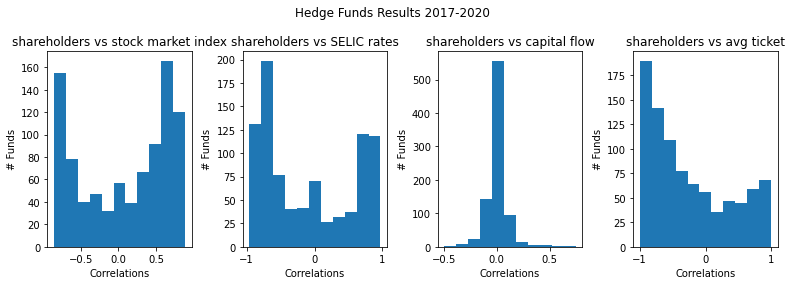

Hedge Fund Data Shape
(1537, 6)


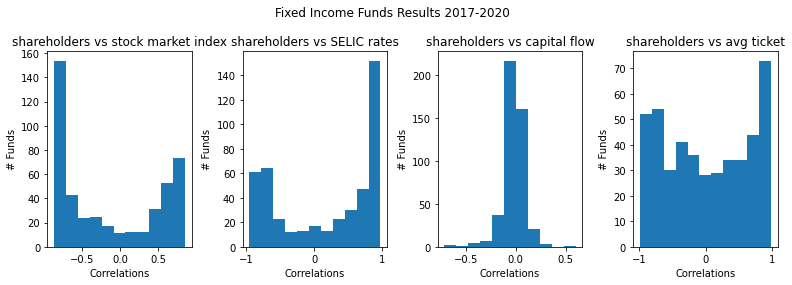

Fixed Income Rate Shape
(473, 6)


In [19]:
lowerLimit="2017-01-01"
upperLimit="2020-12-31"
analyze(lowerLimit, upperLimit)

In [20]:
def yearByYearAnalysis():
    
    lowerLimit = "2017-01-01"
    upperLimit = "2017-12-31"
    analyze(lowerLimit, upperLimit)
    
    lowerLimit = "2018-01-01"
    upperLimit = "2018-12-31"
    analyze(lowerLimit, upperLimit)
    
    lowerLimit = "2019-01-01"
    upperLimit = "2019-12-31"
    analyze(lowerLimit, upperLimit)
    
    lowerLimit = "2020-01-01"
    upperLimit = "2020-12-31"
    analyze(lowerLimit, upperLimit)

In [21]:
yearByYearAnalysis

<function __main__.yearByYearAnalysis()>

<AxesSubplot:xlabel='Date'>

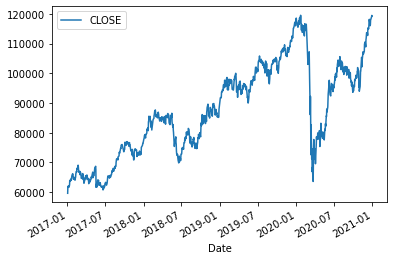

In [22]:
ibovHistoricClose.plot()

In [23]:
def plotHistoricIbovData(ibov):

    ibovHistoric2017 = ibov.history(start="2016-12-31",end="2018-1-1")
    ibovHistoric2018 = ibov.history(start="2017-12-31",end="2019-1-1")
    ibovHistoric2019 = ibov.history(start="2018-12-31",end="2020-1-1")
    ibovHistoric2020 = ibov.history(start="2019-12-31",end="2021-1-1")

    ibovHistoric2017 = ibovHistoric2017[["Close"]] 
    ibovHistoric2018 = ibovHistoric2018[["Close"]] 
    ibovHistoric2019 = ibovHistoric2019[["Close"]] 
    ibovHistoric2020 = ibovHistoric2020[["Close"]] 

    fig, axs = plt.subplots(2, 2, sharex=False, sharey=False)
    fig.set_size_inches(10,6)
    plt.suptitle("Ibovespa yearly trend")

    axs[0][0].plot(ibovHistoric2017)
    axs[0][0].set_title("Ibovespa - 2017")
    axs[0][0].set_xlabel("Date")
    axs[0][0].set_ylabel("Value")  


    axs[1][0].plot(ibovHistoric2018)
    axs[1][0].set_title("Ibovespa - 2018")
    axs[1][0].set_xlabel("Value")
    axs[1][0].set_ylabel("Date")  

    axs[0][1].plot(ibovHistoric2019)
    axs[0][1].set_title("Ibovespa - 2019")
    axs[0][1].set_xlabel("Date")
    axs[0][1].set_ylabel("Value")  

    axs[1][1].plot(ibovHistoric2020)
    axs[1][1].set_title("Ibovespa - 2020")
    axs[1][1].set_xlabel("Date")
    axs[1][1].set_ylabel("Value")      

    plt.tight_layout() 
    plt.show()

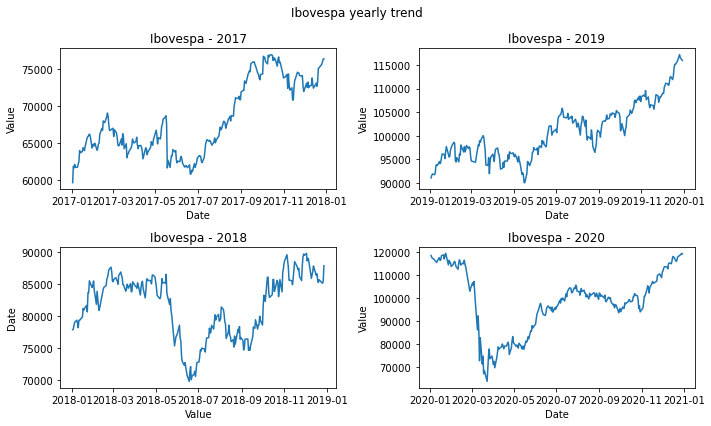

In [24]:
plotHistoricIbovData(ibov)

In [25]:

def plotHistoricSelicData(selicData):
    
    selicData = selicData.reset_index()
    selicData2017 = selicData[((selicData["data"]>'2016-12-31') & (selicData["data"]<'2018-01-01'))].sort_values("data") 
    selicData2018 = selicData[((selicData["data"]>'2017-12-31') & (selicData["data"]<'2019-01-01'))].sort_values("data") 
    selicData2019 = selicData[((selicData["data"]>'2018-12-31') & (selicData["data"]<'2020-01-01'))].sort_values("data") 
    selicData2020 = selicData[((selicData["data"]>'2019-12-31') & (selicData["data"]<'2021-01-01'))].sort_values("data") 

    selicData2017=selicData2017.set_index('data')
    selicData2018=selicData2018.set_index('data')
    selicData2019=selicData2019.set_index('data')
    selicData2020=selicData2020.set_index('data')




    fig, axs = plt.subplots(2, 2, sharex=False, sharey=False)
    fig.set_size_inches(10,6)
    plt.suptitle("SELIC graph")

    axs[0][0].plot(selicData2017)
    axs[0][0].set_title("SELIC - 2017")
    axs[0][0].set_xlabel("Date")
    axs[0][0].set_ylabel("Value")  


    axs[1][0].plot(selicData2018)
    axs[1][0].set_title("SELIC - 2018")
    axs[1][0].set_xlabel("Value")
    axs[1][0].set_ylabel("Date")  

    axs[0][1].plot(selicData2019)
    axs[0][1].set_title("SELIC - 2019")
    axs[0][1].set_xlabel("Date")
    axs[0][1].set_ylabel("Value")  

    axs[1][1].plot(selicData2020)
    axs[1][1].set_title("SELIC - 2020")
    axs[1][1].set_xlabel("Date")
    axs[1][1].set_ylabel("Value")      

    plt.tight_layout() 
    plt.show()

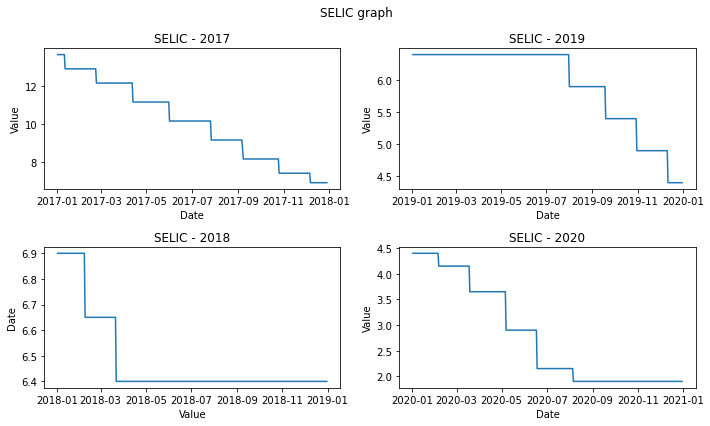

In [26]:
plotHistoricSelicData(selicData)

In [27]:
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import unidecode

In [29]:
firstFundFilterLayer = fundList[fundList["TP_FUNDO"]=="FI"]
firstFundFilterLayer = firstFundFilterLayer[firstFundFilterLayer["DT_REG"]<"2017-01-01"]
firstFundFilterLayer = firstFundFilterLayer[(firstFundFilterLayer["SIT"]=="EM FUNCIONAMENTO NORMAL")]
firstFundFilterLayer = firstFundFilterLayer.drop_duplicates(subset=['CNPJ'], keep='last')

In [30]:
insightsHedgeFund_Dump=pd.read_csv("hedgeFund_dump_2017-01-01-2020-12-31.csv")
insightsFI_Dump=pd.read_csv("fixedIncome_dump_2017-01-01-2020-12-31.csv")

insightsHedgeFund_Dump=insightsHedgeFund_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]
insightsFI_Dump=insightsFI_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]

insightsHedgeFund_Dump=insightsHedgeFund_Dump.set_index("CNPJ")
insightsFI_Dump=insightsFI_Dump.set_index("CNPJ") 



In [31]:
def plot_wordcloud(parsed, clusterCount, graphTitle,stopwordsClass):

    stopwords = set(STOPWORDS)
    #The stopwords below are set to avoid irrelevant information being displayed on the wordclouds.
    #As an example, Fdo. is an abbreviation for Fundo, Inv. for Investimento and FI for Fundo de Investimento.
    stopwords.update(["INVESTIMENTO", "COTAS", "QUOTAS", "DE", "FUNDO", "FEEDER", "EM", "FDO", "INV", "FDOS", 
                      "INVES","FUNDOS","FICFI","FI","FUND"])
    stopwords.update(stopwordsClass)


    for i in range(0,clusterCount):    
        consolidated = parsed[parsed['resultKmeans']==i]
        consolidated = consolidated['DENOM_SOCIAL']

        text = ""
        for a in consolidated:
            text = text + " " + a
        
        text = unidecode.unidecode(text)
        #Replacing common abbreviations to their longer versions
        text = text.replace(" LP ", " LONGO PRAZO ")
        text = text.replace(" CRED PRIV ", " CREDITO PRIVADO ")

        wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=20, background_color="white").generate(text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("{} - Cluster #{}".format(graphTitle,i+1))
        plt.savefig("{}_{}.png".format(graphTitle,i+1))
        plt.show()

In [32]:
def test_kmeans(maxClusters,data):

    wcss=[]

    for i in range(1,maxClusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data[['IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']].dropna())    
        wcss = wcss + [kmeans.inertia_] 
    plt.plot(range(1,20),wcss) 
    
    

In [33]:
def run_kmeans(clusterCount,data):

    kmeans = KMeans(n_clusters=clusterCount, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data[['IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']].dropna())

    k_means_labels = kmeans.labels_
    k_means_cluster_centers = kmeans.cluster_centers_

    print("Centroids:")
    print(k_means_cluster_centers)

    return k_means_labels, k_means_cluster_centers


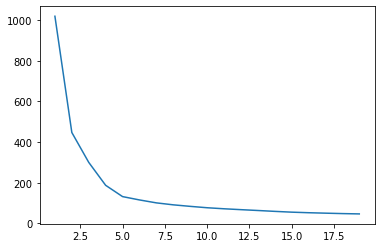

In [34]:
test_kmeans(20,insightsHedgeFund_Dump)

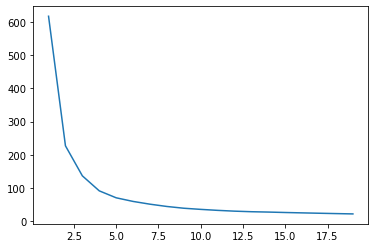

In [35]:
test_kmeans(20,insightsFI_Dump)

In [36]:
stopwordsClassHedgeFund = ['MULTIMERCADO','FIM','ADVISORY']
clusterCountHedgeFund = 4
k_means_labels_HedgeFund, k_means_cluster_centers_HedgeFund = run_kmeans(clusterCountHedgeFund, insightsHedgeFund_Dump)

stopwordsFI = ['RF','RENDA FIXA', 'RENDA', 'FIXA','ADVISORY','FIRF']
clusterCountFI = 4
k_means_labels_FI, k_means_cluster_centers_FI = run_kmeans(clusterCountFI, insightsFI_Dump)

Centroids:
[[ 0.59669626 -0.65735017 -0.00213386  0.5603531   0.09880409]
 [-0.55400735  0.61310566  0.00334551 -0.67578891  0.0997698 ]
 [ 0.49752044 -0.5782494   0.01885392 -0.59301413  0.11281151]
 [-0.63296739  0.6931633  -0.00624292  0.524798    0.07951681]]
Centroids:
[[-0.66782339  0.76615783 -0.02208655  0.67938411  0.06379355]
 [ 0.61554324 -0.65258309 -0.02288378 -0.61965317  0.08346911]
 [-0.64413181  0.74280587  0.00416805 -0.5087524   0.06279712]
 [ 0.51790213 -0.55150818 -0.02442948  0.36614453  0.07314225]]


In [39]:
def print_wordcloud(dataSource,k_means_labels,clusterCount,title,stopwordsClass):
    transposed = pd.DataFrame(data=k_means_labels)
    parsed = dataSource.dropna().reset_index().join(transposed)
    parsed = parsed.set_index("CNPJ")
    parsed = parsed.rename(columns={0:"resultKmeans"})
    lista_interpretada = firstFundFilterLayer[["CNPJ","DENOM_SOCIAL"]].set_index("CNPJ")
    lista_interpretada=lista_interpretada.reset_index().rename(columns={"CNPJ_FUNDO":"CNPJ"}).set_index("CNPJ") 
    parsed = parsed.join(lista_interpretada) 
    plot_wordcloud(parsed, clusterCount, title,stopwordsClass)
    print("{} Shape".format(title))
    print(parsed.shape)
 

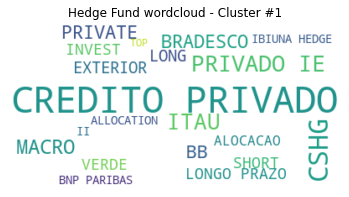

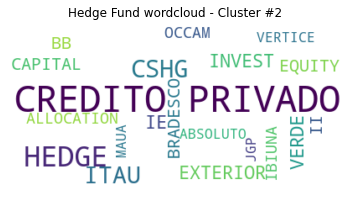

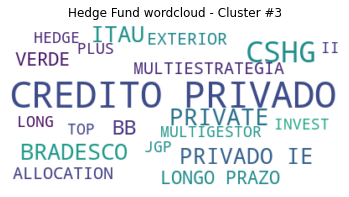

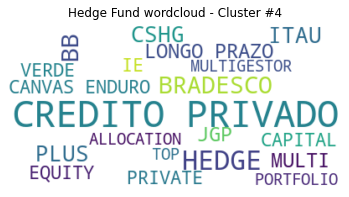

Hedge Fund wordcloud Shape
(857, 7)


In [40]:
print_wordcloud(insightsHedgeFund_Dump,k_means_labels_FI,clusterCountHedgeFund,"Hedge Fund wordcloud",stopwordsClassHedgeFund)

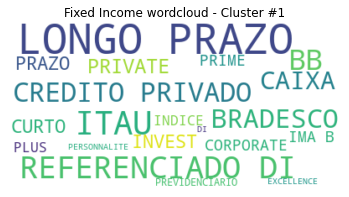

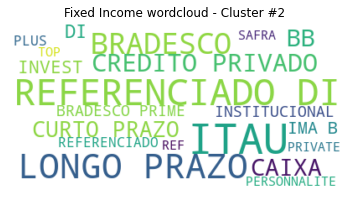

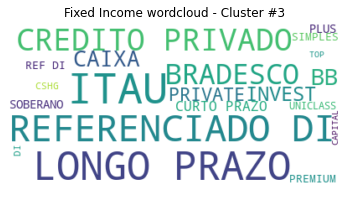

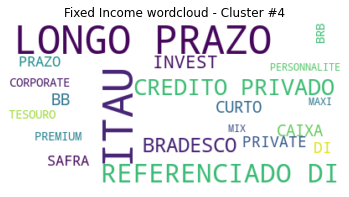

Fixed Income wordcloud Shape
(455, 7)


In [41]:
print_wordcloud(insightsFI_Dump,k_means_labels_HedgeFund,clusterCountFI,"Fixed Income wordcloud",stopwordsFI)